# DataCamp Certification Case Study

### Project Brief

You have been hired as a data scientist at Discount Motors, a used car dealership in the UK. The dealership is expanding and has hired a large number of junior salespeople. Although promising, these junior employees have difficulties pricing used cars that arrive at the dealership. Sales have declined 18% in recent months, and management would like your help designing a tool to assist these junior employees.

To start with, they would like you to work with the Toyota specialist to test your idea(s). They have collected some data from other retailers on the price that a range of Toyota cars were listed at. It is known that cars that are more than £1500 above the estimated price will not sell. The sales team wants to know whether you can make predictions within this range.

You will need to present your findings in two formats:
- You must submit a written report summarising your analysis to your manager. As a data science manager, your manager has a strong technical background and wants to understand what you have done and why. 
- You will then need to share your findings with the head of sales in a 10 minute presentation. The head of sales has no data science background but is familiar with basic data related terminology. 

The data you will use for this analysis can be accessed here: `"data/toyota.csv"`

## Setup Colab

In [ ]:
try:
    from google.colab import drive

    drive.mount('/content/gdrive')
    
    %rm -r '/content/sample_data' 
    %mkdir '/content/data'
    %cp '/content/gdrive/MyDrive/Colab Notebooks/datacamp/Data Scientist Certification/data/toyota.csv' '/content/data/toyota.csv'
except:
    pass

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
rm: cannot remove '/content/sample_data': No such file or directory
mkdir: cannot create directory ‘/content/data’: File exists


## Setup notebook

In [ ]:
import numpy as np
print(f'Numpy version: {np.__version__}')

rng = np.random.default_rng(9901)
np.random.seed(seed=9901)

import matplotlib
import matplotlib.pyplot as plt
print(f'Matplotlib version: {matplotlib.__version__}')

import seaborn
import seaborn as sns
print(f'Seaborn version: {seaborn.__version__}')

import pandas as pd
print(f'Pandas version: {pd.__version__}')

Numpy version: 1.21.6
Matplotlib version: 3.2.2
Seaborn version: 0.11.2
Pandas version: 1.3.5


In [ ]:
df_raw = pd.read_csv('data/toyota.csv')
df_raw.sample(3)


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
1286,Yaris,2016,9495,Automatic,26191,Petrol,30,58.0,1.3
1061,Yaris,2017,9495,Manual,12971,Petrol,145,66.0,1.0
4295,Aygo,2019,10995,Manual,3500,Petrol,145,57.7,1.0


There are no missing values. Some columns viz `model`, `transmission` and `fuelType` can be encoded as categorical.

In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6738 non-null   object 
 1   year          6738 non-null   int64  
 2   price         6738 non-null   int64  
 3   transmission  6738 non-null   object 
 4   mileage       6738 non-null   int64  
 5   fuelType      6738 non-null   object 
 6   tax           6738 non-null   int64  
 7   mpg           6738 non-null   float64
 8   engineSize    6738 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 473.9+ KB


In [ ]:
df_raw.describe()

,year,price,mileage,tax,mpg,engineSize
count,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000
mean,2016.748145,12522.391066,22857.413921,94.697240,63.042223,1.471297
std,2.204062,6345.017587,19125.464147,73.880776,15.836710,0.436159
min,1998.000000,850.000000,2.000000,0.000000,2.800000,0.000000
25%,2016.000000,8290.000000,9446.000000,0.000000,55.400000,1.000000
50%,2017.000000,10795.000000,18513.000000,135.000000,62.800000,1.500000
75%,2018.000000,14995.000000,31063.750000,145.000000,69.000000,1.800000
max,2020.000000,59995.000000,174419.000000,565.000000,235.000000,4.500000


In [ ]:
df_raw.mileage.nunique()

5699

It can be useful to create buckets for `mileage` as the level of granularity in the raw data doesn't give much additional information. A car that has say 10,000 miles is roughly the same as one with 11,000 miles in a customer's head I assume. 
</br></br>
We should ask sales what they would consider as good thresholds, a conservative choice for how to bucketise the data is simply py decile which will reduce the number of unique values from thousands to 10.

In [ ]:
pd.qcut(df_raw.mileage, q=10, retbins=False)

0        (22687.0, 28023.0]
1        (18513.0, 22687.0]
2        (22687.0, 28023.0]
3        (14409.6, 18513.0]
4        (34583.6, 46498.6]
               ...         
6733     (28023.0, 34583.6]
6734     (34583.6, 46498.6]
6735     (34583.6, 46498.6]
6736    (46498.6, 174419.0]
6737     (34583.6, 46498.6]
Name: mileage, Length: 6738, dtype: category
Categories (10, interval[float64, right]): [(1.999, 4070.8] < (4070.8, 7800.0] < (7800.0, 11000.0] <
                                            (11000.0, 14409.6] ... (22687.0, 28023.0] <
                                            (28023.0, 34583.6] < (34583.6, 46498.6] <
                                            (46498.6, 174419.0]]

Exploring categorical features

What are the most common models?

In [ ]:
df_model_counts = df_raw['model'].value_counts()
df_model_counts

 Yaris            2122
 Aygo             1961
 Auris             712
 C-HR              479
 RAV4              473
 Corolla           267
 Prius             232
 Avensis           115
 Verso             114
 Hilux              86
 GT86               73
 Land Cruiser       51
 PROACE VERSO       15
 Supra              12
 Camry              11
 IQ                  8
 Urban Cruiser       4
 Verso-S             3
Name: model, dtype: int64

This is an imbalanced dataset: Yaris and Aygo are by far the more popular models. This must be taken into consideration when building the model.

## Explore the Data 

In [ ]:
def encode(df: pd.DataFrame) -> pd.DataFrame:
    df_enc = df.copy()
    categorical_features = ['model', 'fuelType', 'transmission']
    for cat in categorical_features:
        df_enc[cat] = df_enc[cat].astype('category')
    # df_enc['year_cat'] = df_enc['year'].astype('category')
    df_enc['tax'] = df_enc['tax'].astype(np.int16)
    df_enc['price'] = df_enc['price'].astype(np.int32)
    # df_enc['year'] = df_enc['year'].astype(np.int32)
    return df_enc


In [ ]:
def load_data_eda() -> pd.DataFrame:
    df = pd.read_csv('data/toyota.csv')
    df = encode(df)
    return df


In [ ]:
df_eda = load_data_eda()
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   model         6738 non-null   category
 1   year          6738 non-null   int64   
 2   price         6738 non-null   int32   
 3   transmission  6738 non-null   category
 4   mileage       6738 non-null   int64   
 5   fuelType      6738 non-null   category
 6   tax           6738 non-null   int16   
 7   mpg           6738 non-null   float64 
 8   engineSize    6738 non-null   float64 
dtypes: category(3), float64(2), int16(1), int32(1), int64(2)
memory usage: 271.0 KB


Let's take a first view of the distribution of the different numeric features and how they relate to price and to each other.

What's the distribution of price across all models?

It is skewed on the left i.e. there are more models with lower price that models with high price.

#### Explore data distribution

The ECDF of price follows the theoretical CDF of a log-normal distribution with same mean and standard deviation very closely. Log-normal is the appropriate distribution here since a negative price doesn't make sense. Therefore we can reach the conclusion that price follows a log-normal distribution. If $X$ is price then if in our inference we want to deal with a normally distributed price we should use $Y = log(X)$ as our target.

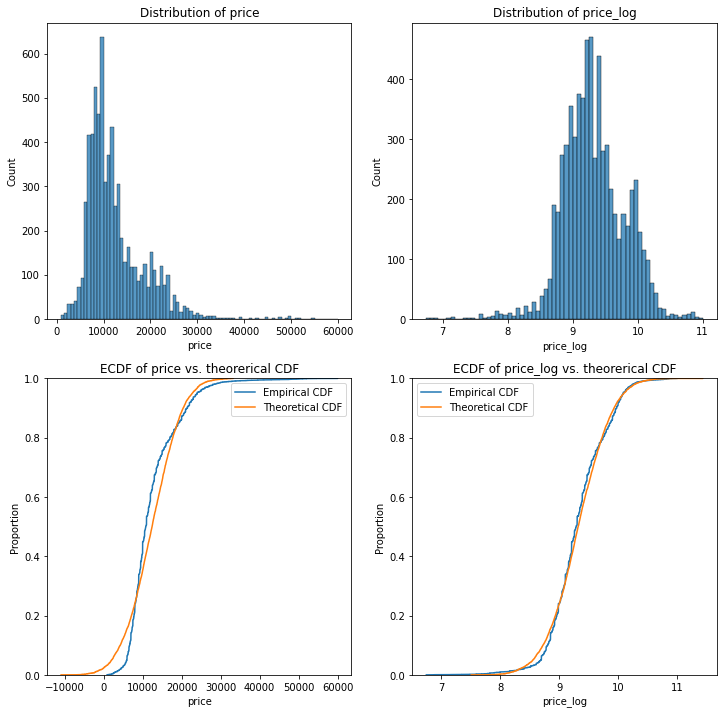

In [ ]:
df_eda['price_log'] = np.log(df_eda['price'])

_, axs = plt.subplots(2, 2, sharey=False, figsize=(12, 12))

def plot_ecdf_cdf(df, xs, axs):
    for i, x in enumerate(xs):
        sns.histplot(data=df, x=x, ax=axs[0][i])
        _ = axs[0][i].set_title(f'Distribution of {x}')

        sns.ecdfplot(data=df_eda, x=x, label='Empirical CDF', 
                     ax=axs[1][i])
        sns.ecdfplot(
            rng.normal(df_eda[x].mean(), df_eda[x].std(), df_eda.shape[0]), 
            ax=axs[1][i], 
            label='Theoretical CDF',
        )
        _ = axs[1][i].set_title(f'ECDF of {x} vs. theorerical CDF')
        _ = axs[1][i].legend()

plot_ecdf_cdf(df_eda, ['price', 'price_log'], axs)

How is price distributed for each model?

As expected price vary a lot based on the model. You cannot buy a Supra for less than around £50,000 and there's no Auris that is more expensive than around £20,000.

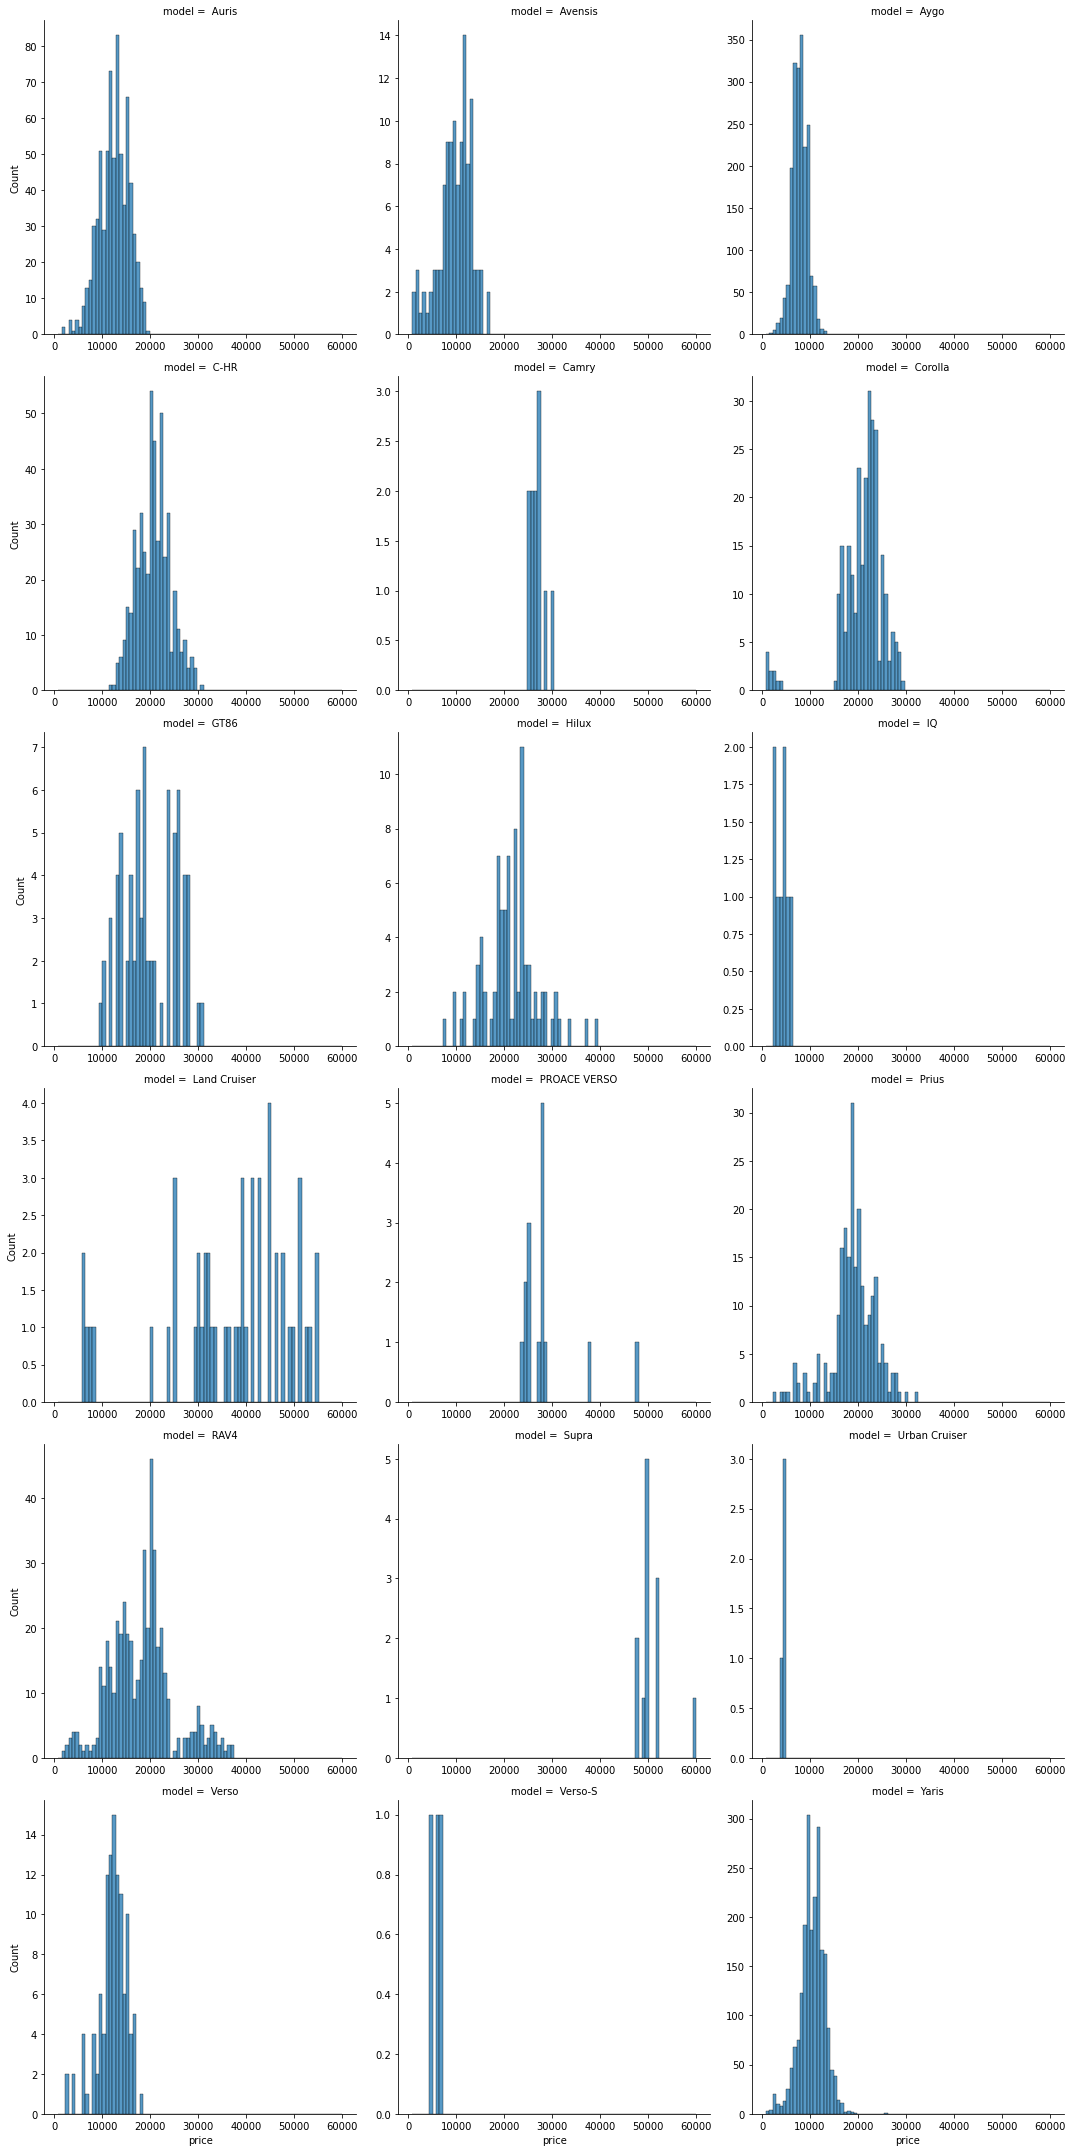

In [ ]:
g = sns.displot(data=df_eda, x='price', col='model', col_wrap=3, 
                facet_kws=dict(sharex=False, sharey=False))

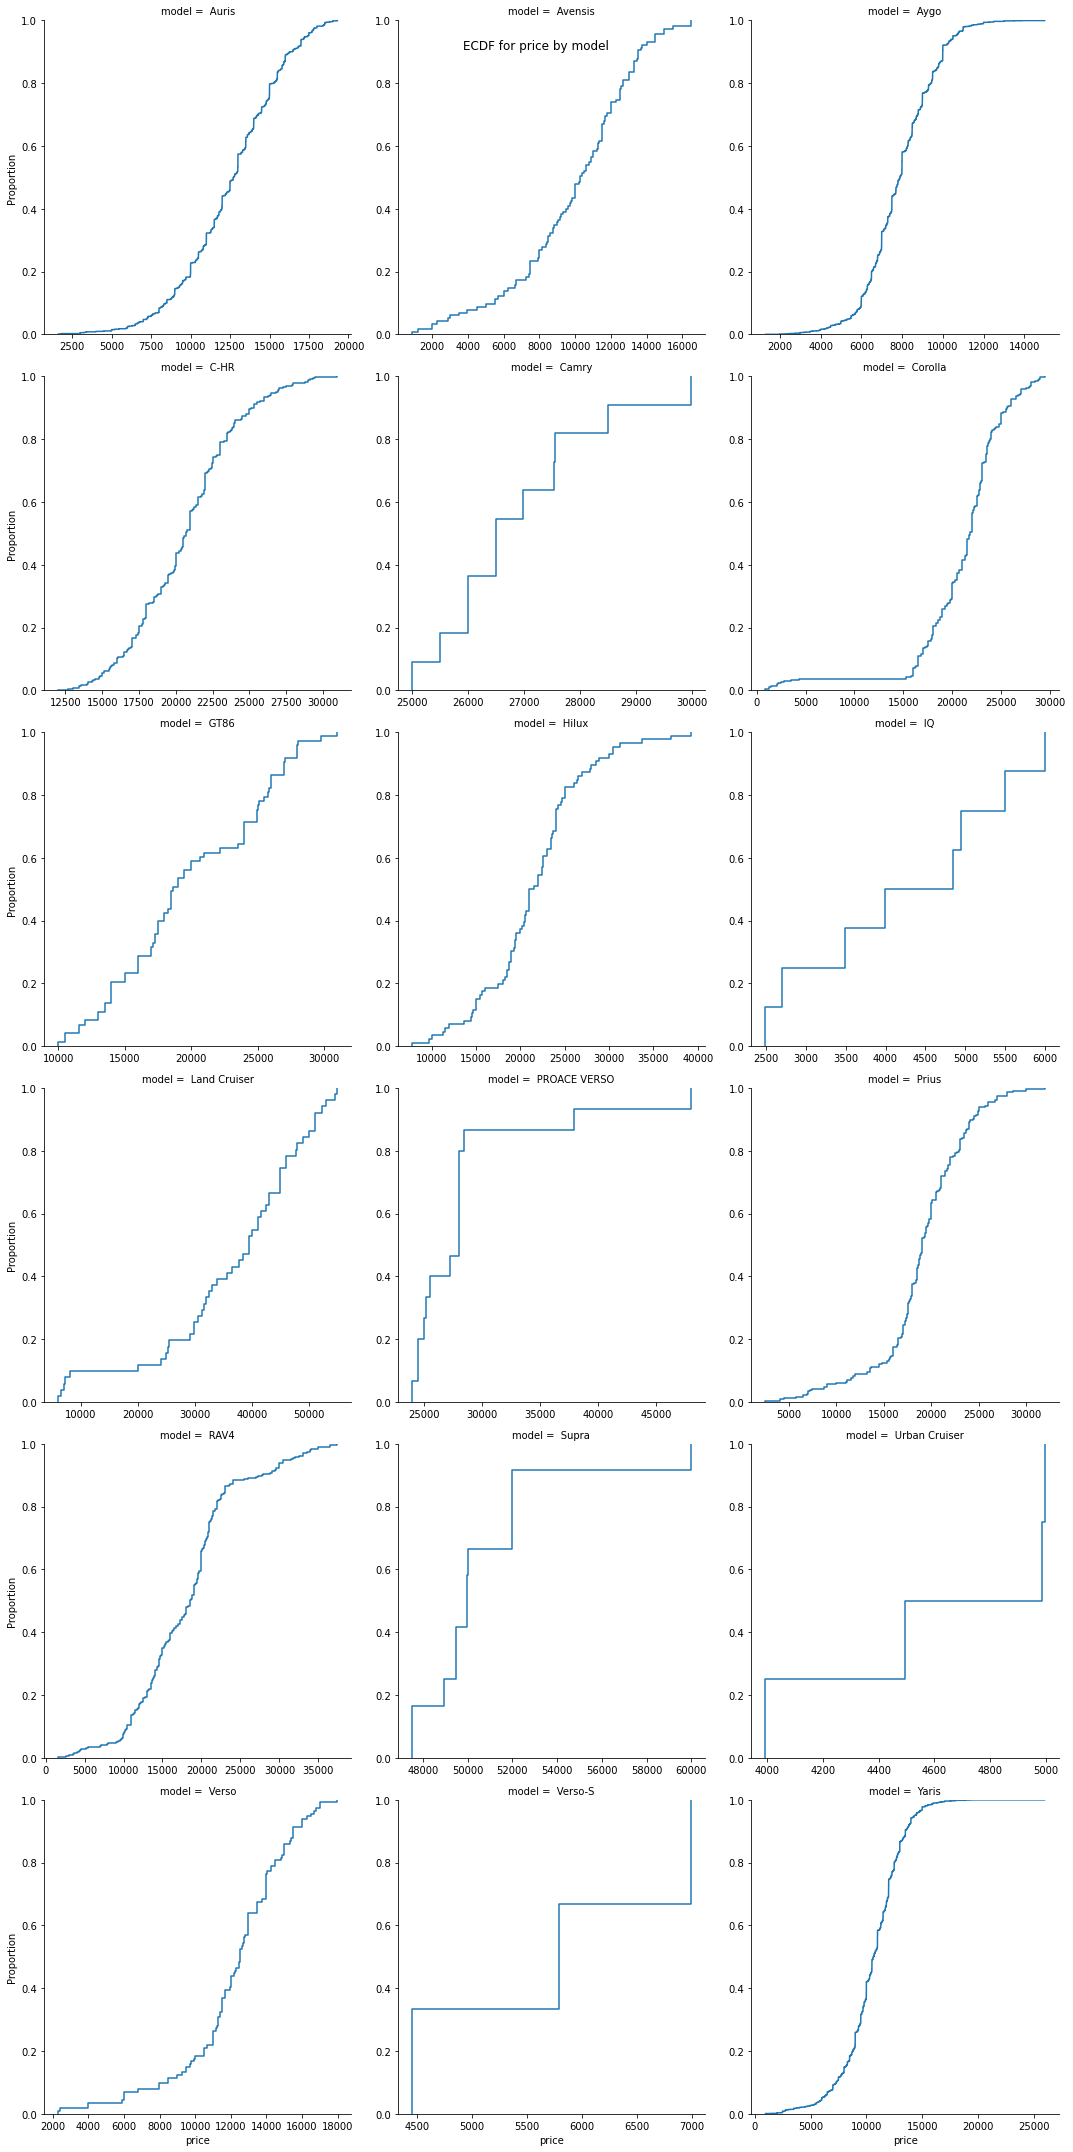

In [ ]:
g = sns.displot(data=df_eda, x='price', col='model', col_wrap=3, kind='ecdf',
                facet_kws=dict(sharex=False, sharey=False))
_ = g.figure.suptitle('ECDF for price by model')

Another way to visualise it is with a joint plot

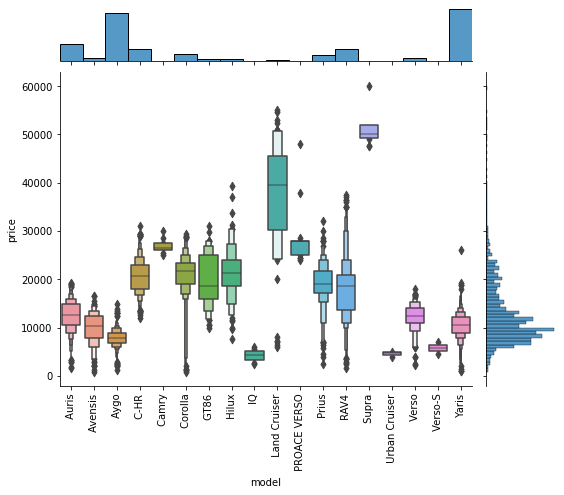

In [ ]:
g = sns.JointGrid(data=df_eda, x='model', y='price')
g.plot(sns.boxenplot, sns.histplot)
g.ax_joint.tick_params(axis='x', labelrotation=90)
g.figure.set_size_inches(8, 6)

A few observations can be made by looking at these plots:
1. price seems to be positively correlated with engine size. This makes sense intuitively as bigger engine size means a more powerful and higher end car
2. tax and engine size seem to be roughly positively correlated. This also makes sense for the same reason mentioned above
3. tax and mpg seem to be generally negatively correlated, there seems to be a few outliers though. Again this makes intuitive sense as say sport cars will have a lower mpg than utility cars, be more expensive and be taxed more.
4. mileage is negatively correlated with price. Again this makes intuitive sense as the car is more used and will be in worst overall conditions.
5. price is positively correlated with year. Again, no surprises here.

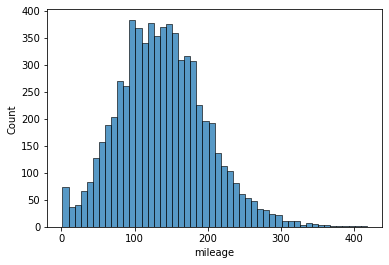

In [ ]:
sns.histplot(np.sqrt(df_eda.mileage))
plt.show()

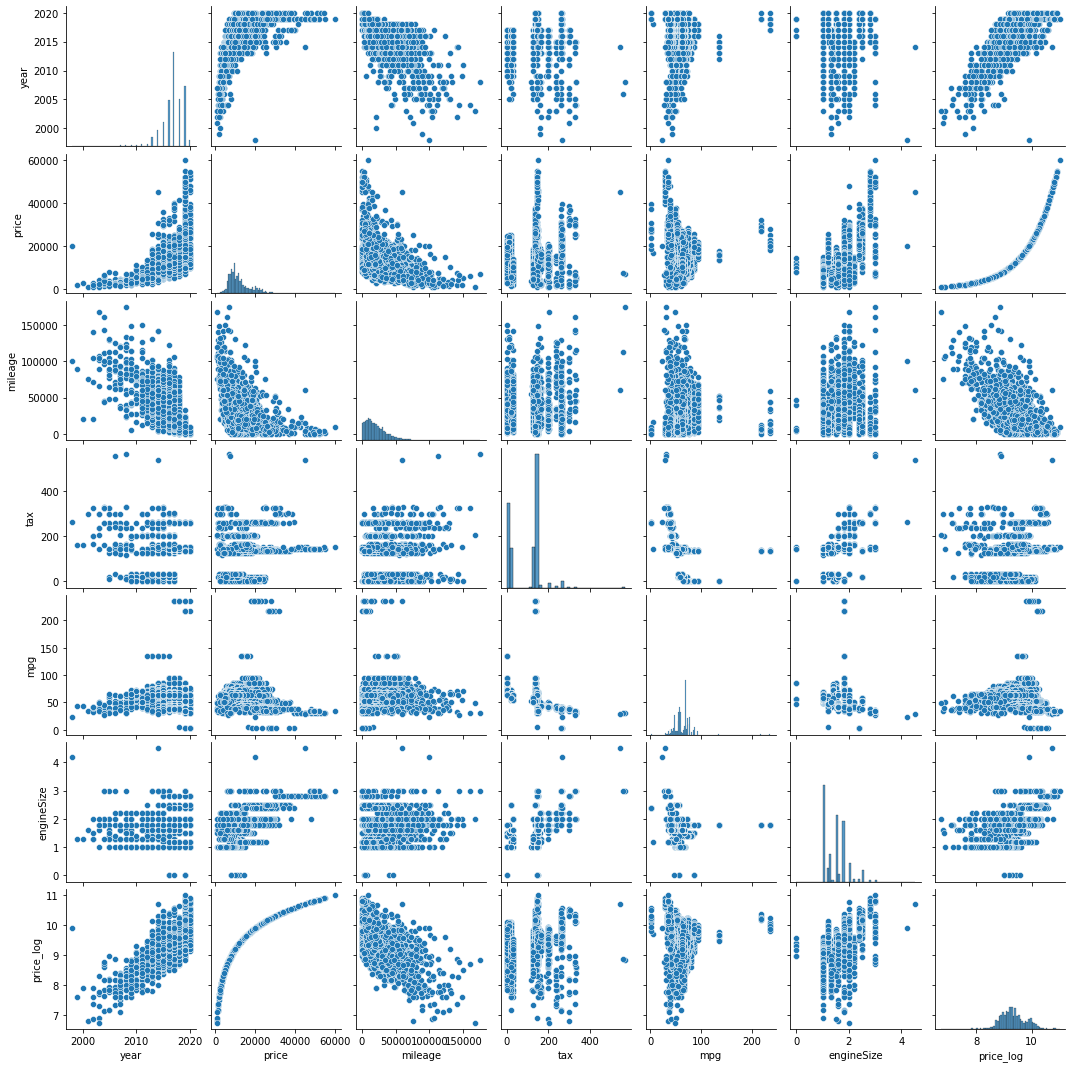

In [ ]:
df_numerical_features = df_eda.select_dtypes('number')

g = sns.pairplot(df_eda)
g.figure.set_figheight(15.)
g.figure.set_figwidth(15.)

In [ ]:
categorical_features = df_eda.select_dtypes(exclude='number')
categorical_features.sample(3)

,model,transmission,fuelType
3305,Auris,Automatic,Hybrid
2816,Yaris,Manual,Petrol
6356,Avensis,Manual,Diesel


These plots tell that:
1. hybrid cars tend to more expensive than cars that use other fuels
2. the same can be said for cars with automatic transmission
3. the year a car was produced is inversely correlated with its price

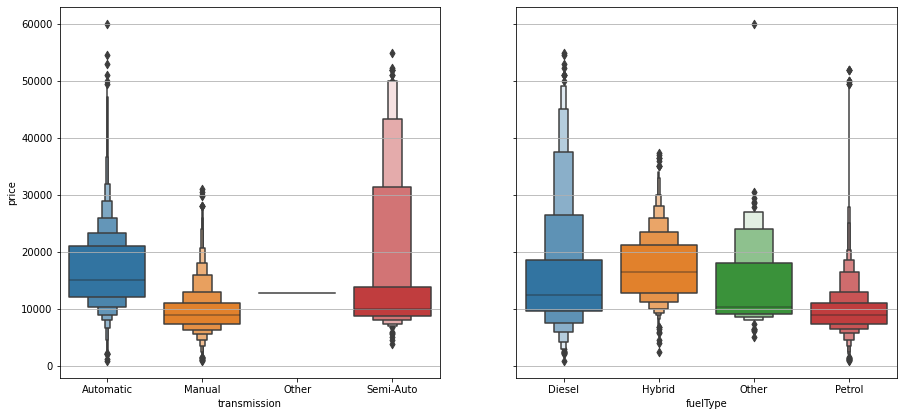

In [ ]:
fig = plt.figure(figsize=(15., 15.))
for i, cat in enumerate(categorical_features.columns[1::]):
    ax = plt.subplot(2, 2, i + 1)
    ax.grid(True)
    _ = sns.boxenplot(data=df_eda, y='price', x=cat, ax=ax)
    if i >= 2:
        ax.tick_params(axis='x', labelrotation=90)
    if i % 2 != 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])

### Outliers

Using the 3-sigma rule, let's take a look at how many cars are above that threshold.

In [ ]:
mean_price = df_eda['price'].mean()
sigma3_price = 3 * df_eda['price'].std()
df_3sigma = df_eda[
    (df_eda['price'] > mean_price + sigma3_price) 
        | (df_eda['price'] < mean_price - sigma3_price)
]
df_3sigma.sample(5)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,price_log
6708,Supra,2019,49499,Automatic,10,Petrol,145,34.5,3.0,10.809708
6698,Land Cruiser,2014,44990,Automatic,60000,Diesel,540,29.7,4.5,10.714196
427,RAV4,2019,31995,Automatic,11728,Hybrid,140,49.6,2.5,10.373335
6657,Land Cruiser,2019,42444,Semi-Auto,10083,Diesel,145,30.1,2.8,10.655941
556,RAV4,2019,32860,Automatic,4271,Hybrid,135,49.6,2.5,10.400011


These cars are mostly SUVs, pick up trucks or sport cars. It make semse that their price is so high.

In [ ]:
df_3sigma_by_year = df_3sigma.groupby(['year']).count()

print(f'Prices ±3 sigma from the mean price: {df_3sigma_by_year.model.sum()}')
print(f'Total number of cars in the dataset: {df_eda.shape[0]}')
print(f'Percentange of prices ±3 sigma from the mean price: \
{df_3sigma_by_year.model.sum() / df_eda.shape[0]:.2%}')


Prices ±3 sigma from the mean price: 76
Total number of cars in the dataset: 6738
Percentange of prices ±3 sigma from the mean price: 1.13%


In [ ]:
index_outliers_3sigma = df_3sigma.index

Given how big the dataset is and how few outliers there are, we can avoid spending too much time looking at them. 
</br></br>
Out of curiousity: the year with the higher proportion of outliers is 2020. The majority of outliers is from car produced in 2019. Since these are cars that are almost new, it makes intuitive sense that outliers are to be found there.

In [ ]:
df_counts = df_eda['year'].value_counts(normalize=False)
df_merge = df_3sigma_by_year.merge(df_counts, how='right', 
                                   right_index=True, left_index=True, sort=True) \
    .fillna(0)[['model', 'year']]
df_ratios = df_merge.apply(
    lambda x: [x[0] / x[1] if x[1] > 0 else 0, x[1] / df_eda.shape[0]], 
    axis=1, result_type='expand'
).rename({0: 'outliers / total', 1: 'year / total'}, axis=1)
df_join = df_merge.join(df_ratios) \
    .rename({'model': 'outliers', 'year': 'total'}, axis=1) \
    .sort_index(ascending=False)
df_join[df_join['outliers'] > 0]


,outliers,total,outliers / total,year / total
2020,17.0,128,0.132812,0.018997
2019,47.0,1286,0.036547,0.190858
2018,1.0,1015,0.000985,0.150638
2017,6.0,2019,0.002972,0.299644
2016,2.0,997,0.002006,0.147967
2015,2.0,525,0.003810,0.077916
2014,1.0,352,0.002841,0.052241


The one outlier for 2014 is an Automatic, Diesel Land Cruiser with 60,000 miles.

In [ ]:
df_eda[(df_eda.year == 2014) & (df_eda.price > 40000)]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,price_log
6698,Land Cruiser,2014,44990,Automatic,60000,Diesel,540,29.7,4.5,10.714196


There's one outlier on many categories. It's a 2019 Supra.

In [ ]:
df_eda[df_eda['price'] == df_eda['price'].max()]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,price_log
6711,Supra,2019,59995,Automatic,9909,Other,150,34.5,3.0,11.002017


In [ ]:
df_eda[df_eda['price'] == df_eda['price'].min()]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,price_log
6427,Avensis,2003,850,Manual,167054,Diesel,205,48.7,2.0,6.745236


### Correlations

1. Price is strongly correlated with engine size, somewhat to year and mildly to tax
2. year is strongly negatively correlated with year
3. tax is somewhat correlated to mpg
</br></br>
Interestingly to me engine size is not hugely negatively correlated with mpg. I'd have assumed that a bigger engine needs more fuel per mile but that doesn't seem to be the case. Which could mean the engine is not only bigger but also more efficient.

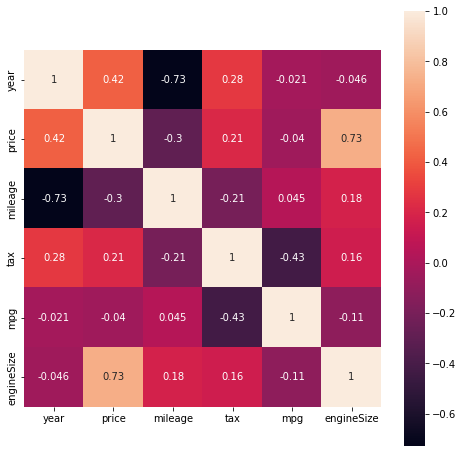

In [ ]:
fig = plt.figure(figsize=(8, 8))
_ = sns.heatmap(df_eda.drop(columns='price_log').corr(), square=True, annot=True)

We can use one-hot encoding to encode `fuelType` and `transmission` and check for some more correlations for example with `engineSize`.
</br></br>
We can learn a lot from that:

1. cars with manual transmission and that use petrol tend to have smaller engines.
2. hybrid cars and automatic cars tend to have the bigger engines. Hybrid has an almost perfect positive correlation with automatic transmission so that's hardly surprising.
3. cars with manual transmissions have an almost perfect positive correlation with using petrol and a negative one with hybrid fuel.
4. engines consuming diesel are somewhat correlated with engine size.

This knowledge can be useful to create interaction terms later on.

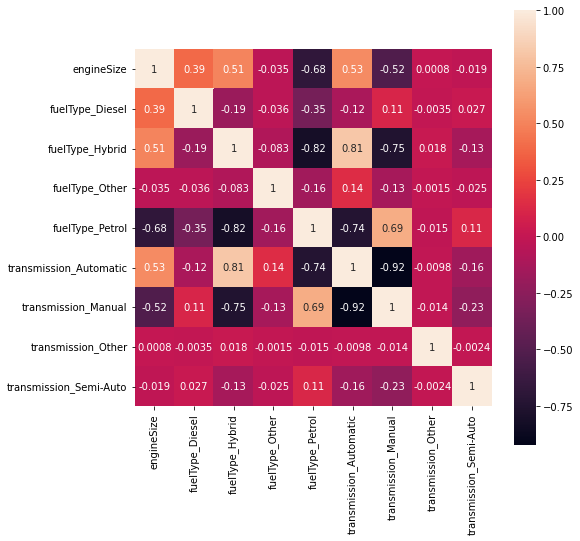

In [ ]:
df_corr = df_eda[['engineSize']].join(
    pd.get_dummies(df_eda[['fuelType', 'transmission']], 
                   drop_first=False)
).corr()
fig = plt.figure(figsize=(8, 8))
_ = sns.heatmap(df_corr, square=True, annot=True)

By adding encoded categorical variables to the correlation matrix we can spot some confounding effects present in some of the features. E.g. price is somewhat correlated to hybrid engines which in turn are correlated with engine size.

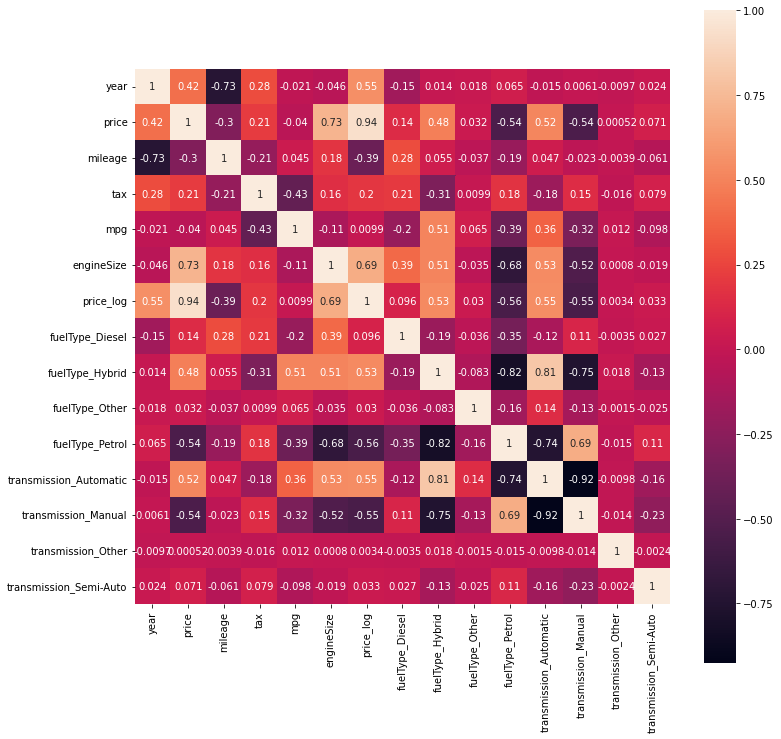

In [ ]:
df_dummies = pd.get_dummies(df_eda[['fuelType', 'transmission']], drop_first=False)
df_corr = df_eda.drop(columns=['fuelType', 'transmission']).join(df_dummies).corr()
fig = plt.figure(figsize=(12, 12))
_ = sns.heatmap(df_corr, square=True, annot=True)

## Prepare the Data

In [ ]:
from sklearn import __version__ as sklearn_version
print(f'Scikit-learn version: {sklearn_version}')

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    RandomizedSearchCV,
)
from sklearn.feature_selection import (
    RFECV,
    mutual_info_regression,
)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sklearn.metrics as metrics

from sklearn.linear_model import (
    LinearRegression, 
    RidgeCV,
    Ridge,
)
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    VotingRegressor,
    StackingRegressor,
)
from sklearn.pipeline import Pipeline, make_pipeline

import xgboost as xgb
print(f'XGB version: {xgb.__version__}')

import scipy.stats as stats

from typing import List, Tuple, Union
from numpy.typing import NDArray

from multiprocessing import cpu_count
n_jobs = cpu_count() // 2

import time

Features = Union[NDArray[float], pd.DataFrame, pd.Series]
Labels = Union[NDArray[float], pd.DataFrame, pd.Series]
Data = Tuple[Features, Labels]

Scikit-learn version: 1.0.2
XGB version: 0.90


In [ ]:
def transform(df: pd.DataFrame) -> pd.DataFrame:
    df_trans = df.copy()
    df_trans['mileage_cat'] = pd.qcut(df['mileage'], q=10, retbins=False)
    df_trans['mpg_sqrt'] = np.sqrt(df_trans['mpg'])
    df_trans.pop('mpg')
    return df_trans

def interactions(df: pd.DataFrame) -> pd.DataFrame:
    df_inter = pd.DataFrame()
    # These interactions don't seem to be meaningful, they don't improve predictions
    # X_train_inter['transmission_Manual__fuelType_Hybrid'] = X_train.transmission_Manual.mul(X_train['fuelType_Hybrid'])
    # X_train_inter['transmission_Other__fuelType_Other'] = X_train.transmission_Other.mul(X_train['fuelType_Other'])
    # X_train_inter['transmission_Semi-Auto__fuelType_Petrol'] = X_train['transmission_Semi-Auto'].mul(X_train['fuelType_Petrol'])
    df_inter['engineSize__transmission_Manual'] = df['engineSize'].mul(df['transmission_Manual'])
    df_inter['engineSize__transmission_Other'] = df['engineSize'].mul(df['transmission_Other'])
    df_inter['engineSize__transmission_Semi-Auto'] = df['engineSize'].mul(df['transmission_Semi-Auto'])
    df_inter['engineSize__fuelType_Hybrid'] = df['engineSize'].mul(df['fuelType_Hybrid'])
    df_inter['engineSize__fuelType_Other'] = df['engineSize'].mul(df['fuelType_Other'])
    df_inter['engineSize__fuelType_Petrol'] = df['engineSize'].mul(df['fuelType_Petrol'])
    return df_inter

def augment(df: pd.DataFrame) -> pd.DataFrame:
    df_aug = df.copy()
    df_inter = interactions(df_aug)
    return df_aug.join(df_inter)

def encode_ml(df: pd.DataFrame) -> pd.DataFrame:
    df_e = encode(df)
    df_dummies = pd.get_dummies(df[['fuelType', 'transmission', 'model']], 
                                drop_first=True)
    df_e = df_e.drop(['fuelType', 'transmission', 'model'], axis=1).join(df_dummies)
    # TODO: try target encoding
    if 'mileage_cat' in df_e.columns:
        df_e['mileage_enc'] = df_e.pop('mileage_cat').cat.codes
    return df_e

def load_data_ml() -> pd.DataFrame:
    df = pd.read_csv('data/toyota.csv')
    # df = clean(df)
    df = transform(df)
    df = encode_ml(df)
    df = augment(df)
    return df


In [114]:
df_ml = load_data_ml()
X = df_ml.drop(columns=['price', 'mileage'])
y = df_ml['price']
X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.2,
                                                random_state=9901)
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.2,
                                                  random_state=9901)
X_train.shape, X_val.shape, X_test.shape, X.shape, y.shape

((4312, 34), (1078, 34), (1348, 34), (6738, 34), (6738,))

#### Mutual Information Score

Mutual information score can also help understanding feature importance, the main difference with correlation being that the relationship between feature and target doesn't need to be linear.

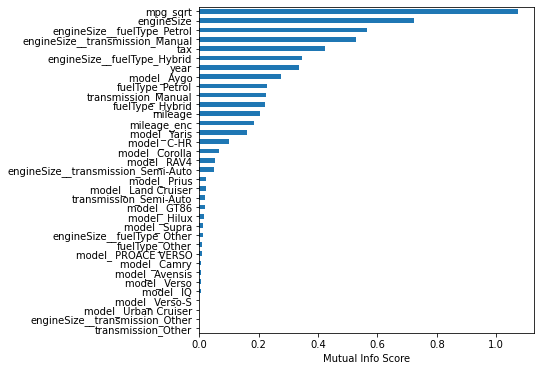

In [ ]:
df_dummies = pd.get_dummies(df_ml).drop(columns=['price'], axis=1)
mi_scores = mutual_info_regression(df_dummies, df_ml['price'])
_, ax = plt.subplots(figsize=(6, 6))
_ = ax.set_xlabel('Mutual Info Score')
df_mi_scores = pd.DataFrame(
    zip(df_dummies.columns, mi_scores), 
    index=df_dummies.columns,
    columns=['names', 'mi_score']
)
ax = df_mi_scores.sort_values(by='mi_score', ascending=True) \
    .plot(kind='barh', ax=ax, legend=False)

In [ ]:
uninformative_features_mi_score = df_mi_scores[df_mi_scores['mi_score'] == 0.0].index
uninformative_features_mi_score 

X_train_mi = X_train.drop(columns=uninformative_features_mi_score)
X_val_mi = X_val.drop(columns=uninformative_features_mi_score)
X_test_mi = X_test.drop(columns=uninformative_features_mi_score)

X_train_mi.shape, X_val_mi.shape, X_test_mi.shape

((4312, 30), (1078, 30), (1348, 30))

## Shortlist Promising Models

**Model evaluation**

From the problem statement, there is a upper bound that defines a bad price that is £1,500 above the actual price. There is no explicit lower bound though. I assume that a model that assigns a price that is lower to the actual price is to be considered a bad one because the business is going to miss on some revenues. Therefore the lower bound for an estimated price will be the actual price.

##### Helper functions

In [ ]:
def rmse(y_true: float, y_pred: float) -> float:
    return metrics.mean_squared_error(y_true, y_pred, squared=False)

neg_rmse = metrics.make_scorer(rmse, greater_is_better=False)

Feature selection using the `RFECV` which does recursive feature elimination using cross-validation. Typically some features will be not useful when it comes to prediction and can be discarded, limiting the noise the estimator sees during training and hopefully allowing it to generalise better.

In [ ]:
def get_selected_features(estimator, 
                          X: Features, 
                          y: Labels, 
                          importance_getter='auto',
                          log_y=True) -> List[str]: 
    y_ = np.log(y) if log_y else y
    selector = RFECV(estimator, cv=5, scoring=neg_rmse, 
                     importance_getter=importance_getter).fit(X, y_)
    selected_features = selector.get_feature_names_out()
    print(f'Total feature count:{X.shape[1]} \
          \tSelected feature count: {len(selected_features)}')
    return selected_features

In [ ]:
def get_scores(y_true, y_pred) -> None:
    rmse = metrics.mean_squared_error(y_true, y_pred, squared=False)
    print(f'RMSE: {rmse:.2f}')
    r2 = metrics.r2_score(y_true, y_pred)
    print(f'R-squared: {r2:.4f}') 

def fit_regressor(estimator, 
                  train_data: Data, 
                  test_data: Data, 
                  scale_input=True,
                  log_y=True):
    X_train, y_train = train_data
    X_test, y_test = test_data

    start = time.time()
    if scale_input:
        regressor = make_pipeline(StandardScaler(), estimator)
    else:
        regressor = estimator
    regressor.fit(X_train, np.log(y_train))
    y_pred = np.exp(regressor.predict(X_test))

    get_scores(y_test, y_pred)    
    end = time.time()
    print(f'Fitting estimator took {end - start:.2f}s')

    return regressor

In [ ]:
def get_residuals(y_true: NDArray[float], y_pred: NDArray[float]) -> NDArray[float]:
    return np.log(y_true) - np.log(y_pred)

def plot_resid_vs_fitted(y_true: NDArray[float], y_pred: NDArray[float]) -> None:
    residuals = get_residuals(y_true, y_pred)
    _, ax = plt.subplots()
    _ = sns.residplot(x=np.log(y_pred), y=residuals, 
                      lowess=True,
                      ax=ax,
                      scatter_kws=dict(alpha=0.5, color='b'),
                      line_kws=dict(color='r', alpha=0.6, lw=1))
    _ = ax.set_xlabel('Fitted Values')
    _ = ax.set_ylabel('Residuals')
    _ = ax.set_title('Residuals vs Fitted Plot')

def plot_qq(y_true: NDArray[float], y_pred: NDArray[float]) -> None:
    _, ax = plt.subplots()
    residuals = get_residuals(y_true, y_pred)
    (osm, osr), (slope, intercept, r) = stats.probplot(residuals, plot=ax)
    _ = ax.set_title('QQ Plot')
    plt.show()

def plot_scale_location(y_true: NDArray[float], y_pred: NDArray[float]) -> None:
    def get_sqrt_abs_std_residuals() -> NDArray[float]:
        residuals = get_residuals(y_true, y_pred)
        std_residuals = residuals / residuals.std()
        return np.sqrt(np.abs(std_residuals))

    _, ax = plt.subplots()
    sqrt_abs_residuals = get_sqrt_abs_std_residuals()
    sns.regplot(x=np.log(y_true), y=sqrt_abs_residuals,
                ax=ax,
                scatter=True,
                lowess=True,
                scatter_kws=dict(alpha=0.5, color='b'),
                line_kws=dict(color='r', lw=1, alpha=0.6))
    _ = ax.set_title('Scale-Location Plot')
    _ = ax.set_ylabel("$\sqrt{Standarized\ residuals}$")
    _ = ax.set_xlabel("Fitted value")

def plot_diagnostics(y_true: NDArray[float], y_pred: NDArray[float]) -> None:
    plot_resid_vs_fitted(y_true, y_pred)
    plot_qq(y_true, y_pred)
    plot_scale_location(y_true, y_pred)

### Linear Regression

In [ ]:
features_lr = get_selected_features(
    LinearRegression(),
    pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns), 
    y,
)
print(f"Selected features: {', '.join(features_lr)}")

Total feature count:34           	Selected feature count: 2
Selected features: year, engineSize


In [ ]:
log_scores = cross_val_score(LinearRegression(), X[features_lr], np.log(y), 
                             scoring='neg_mean_squared_error')
np.exp(log_scores)

array([0.95757054, 0.95898145, 0.97653099, 0.97548477, 0.89781476])

In [ ]:
X_train_lr = X_train[features_lr]
X_val_lr = X_val[features_lr]

In [ ]:
lr_rfe = fit_regressor(LinearRegression(), (X_train_lr, y_train), (X_val_lr, y_val))

RMSE: 2883.55
R-squared: 0.8085
Fitting estimator took 0.01s


The error of the regressor and the $R^2$ score using all the features is much better then the one using a subset of features.

In [ ]:
lr = fit_regressor(LinearRegression(), (X_train, y_train), (X_val, y_val))

RMSE: 1332.20
R-squared: 0.9591
Fitting estimator took 0.04s


Check if the assumptions of linear regression hold:
1. Normality of the target 
2. Normality of the residuals
3. Homoscedasticity of the residuals
4. Linear relationship between features and target
5. Independent obervations

The residuals vs fitted plot shows a line that is tracking the x axis reasonably well. No definitive red flags so far. 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


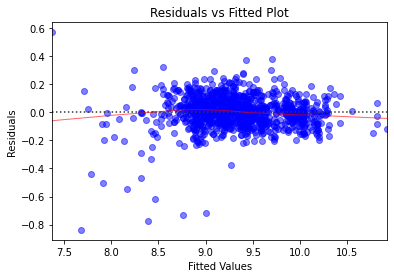

In [ ]:
y_pred_lr = np.exp(lr.predict(X_val))
plot_resid_vs_fitted(y_val, y_pred_lr)

The residuals show a heavy left tail therefore they are not normally distributed. Something needs to be re-examined in the model.

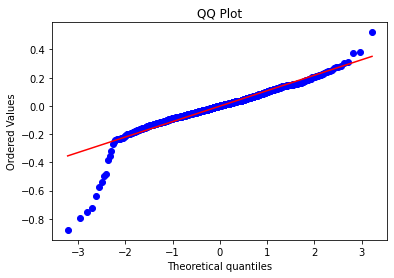

In [ ]:
plot_qq(y_val, y_pred_lr)

The scale-location plot also shows signs of heteroscedasticity (residuals not having constant variance across the domain). This means that the model doesn't fit well certain observations and its predictions are inaccurate and biased.

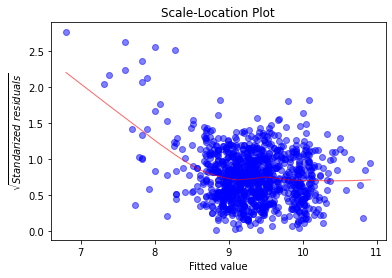

In [ ]:
plot_scale_location(y_val, y_pred_lr)

We can also look at the coefficients to check for multicollinearity, even if they are made a bit less intellegible since we used the logarithm of the price. The coefficients in this case give a "directional" intuition of theie weight. For example year has a big positive influence on the price, while mileage a negative influence. This is in line with my intuitions.

In [ ]:
pd.DataFrame(lr['linearregression'].coef_, 
             index=X_train.columns, 
             columns=['coefficient_log']) \
    .sort_values(by='coefficient_log', ascending=False).head(10)

,coefficient_log
year,0.243757
fuelType_Hybrid,0.231048
fuelType_Petrol,0.094865
model_ RAV4,0.089139
engineSize,0.083061
model_ Land Cruiser,0.074864
model_ C-HR,0.066214
model_ Hilux,0.051474
model_ Prius,0.046067
model_ GT86,0.042917


### Ridge regression

In [ ]:
ridge = fit_regressor(RidgeCV(), (X_train, y_train), (X_val, y_val))

RMSE: 1330.63
R-squared: 0.9592
Fitting estimator took 0.04s


As expected the various plots look very similar to the ones that the linear regression estimators has.

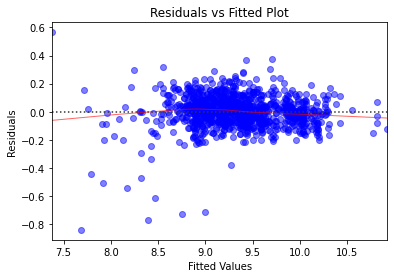

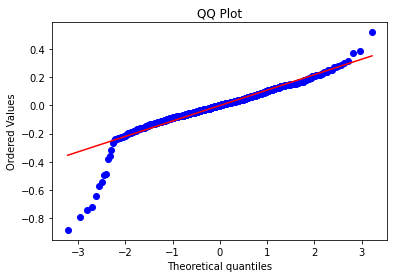

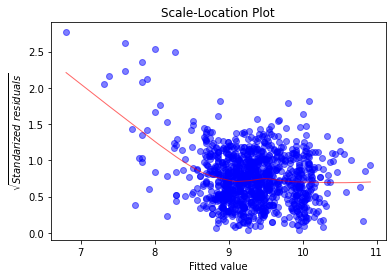

In [ ]:
plot_diagnostics(y_val, np.exp(ridge.predict(X_val)))

### Support Vector Machines

In [ ]:
mk_lsvr = lambda: LinearSVR(dual=False, loss='squared_epsilon_insensitive', random_state=9901)

In [ ]:
features_lsvr = get_selected_features(
    mk_lsvr(),
    pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns),
    y,
)
print(f"Selected features: {', '.join(features_lsvr)}")

Total feature count:34           	Selected feature count: 1
Selected features: engineSize


In [ ]:
X_train_lsvr = X_train[features_lsvr]
X_val_lsvr = X_val[features_lsvr]

Similarly to linear regression, the error of the regressor using all the features is much better then the one using a subset of features. Its $R^2$ score though is again awful while the one of the SVM regressor using a subset of the features is much better.



In [ ]:
lsvr_rfe = fit_regressor(mk_lsvr(), (X_train_lsvr, y_train), (X_val_lsvr, y_val))

RMSE: 4477.61
R-squared: 0.5382
Fitting estimator took 0.01s


In [ ]:
lsvr = fit_regressor(mk_lsvr(), (X_train, y_train), (X_val, y_val))

RMSE: 1336.32
R-squared: 0.9589
Fitting estimator took 0.04s


The plots for the SVM regression are almost identical to the ones for Linear regression.

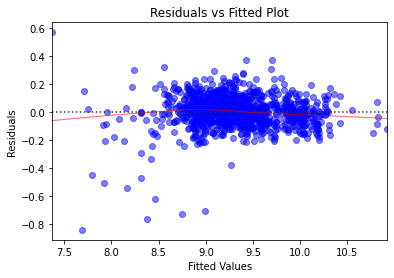

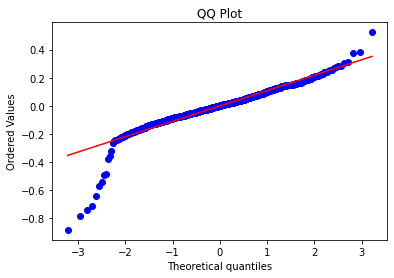

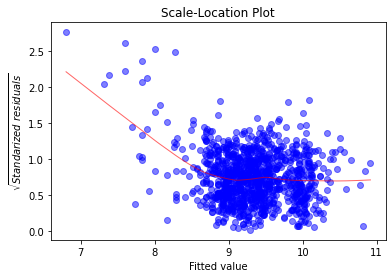

In [ ]:
y_pred_lsvr = np.exp(lsvr.predict(X_val))
plot_diagnostics(y_val, y_pred_lsvr)

Looking at its RMSE, the SVM regressor with a RBF kernel looks very promising.

In [ ]:
svr = fit_regressor(SVR(kernel='rbf', C=1),
                    (X_train, y_train), (X_val, y_val))

RMSE: 1242.73
R-squared: 0.9644
Fitting estimator took 0.55s


### K-Neighbours

K-neighbours also has performance on par with the other estimators.

In [ ]:
kn = fit_regressor(KNeighborsRegressor(n_jobs=n_jobs), (X_train, y_train), (X_val, y_val))

RMSE: 1315.53
R-squared: 0.9601
Fitting estimator took 0.19s


Dropping features with MI score doesn't seem to make a difference for this estimator.



In [ ]:
kn_mi = fit_regressor(KNeighborsRegressor(n_jobs=n_jobs), 
                      (X_train_mi, y_train), (X_val_mi, y_val))

RMSE: 1321.28
R-squared: 0.9598
Fitting estimator took 0.16s


### Decision Tree

Vanilla decision tree also achieves very good performance. Removing features with MI score equal to 0 benefits the estimator.

In [ ]:
dt = fit_regressor(DecisionTreeRegressor(), (X_train, y_train), (X_val, y_val))

RMSE: 1366.07
R-squared: 0.9570
Fitting estimator took 0.03s


In [ ]:
dt_mi = fit_regressor(DecisionTreeRegressor(), 
                      (X_train_mi, y_train), (X_val_mi, y_val))

RMSE: 1340.05
R-squared: 0.9586
Fitting estimator took 0.03s


In [ ]:
def drop_uniformative_features(X_train, X_val, dt, threshold):
    assert X_train.shape[1] == X_val.shape[1]
    df_feat_importances = pd.DataFrame(
        dt.feature_importances_,
        index=X_train.columns,
        columns=['importance'],
    ) 
    # df_feat_importance.sort_values(by='importance', ascending=False)
    uninformative_features = df_feat_importances[
        df_feat_importances.importance < threshold
    ].index
    print(f'Dropping: {uninformative_features.tolist()}')
    X_train_ = X_train.drop(columns=uninformative_features)
    X_val_ = X_val.drop(columns=uninformative_features)
    assert X_train.shape[1] == X_val.shape[1]
    return (X_train_, X_val_)

Dropping uniformative features boost performance quite a bit. Interestingly, interactions and one-hot encoded features are almost all discarded.

In [ ]:
X_train_dt_, X_val_dt_ = drop_uniformative_features(
   X_train, X_val, dt['decisiontreeregressor'], 0.0005
)

dt_ = fit_regressor(DecisionTreeRegressor(), (X_train_dt_, y_train), (X_val_dt_, y_val))

Dropping: ['fuelType_Hybrid', 'fuelType_Other', 'fuelType_Petrol', 'transmission_Other', 'transmission_Semi-Auto', 'model_ Aygo', 'model_ Camry', 'model_ Corolla', 'model_ GT86', 'model_ Hilux', 'model_ IQ', 'model_ PROACE VERSO', 'model_ Supra', 'model_ Urban Cruiser', 'model_ Verso-S', 'engineSize__transmission_Other', 'engineSize__transmission_Semi-Auto', 'engineSize__fuelType_Hybrid', 'engineSize__fuelType_Other']
RMSE: 1359.09
R-squared: 0.9575
Fitting estimator took 0.02s


In [ ]:
X_train_mi_dt_, X_val_mi_dt_ = drop_uniformative_features(
    X_train_mi, X_val_mi, dt_mi['decisiontreeregressor'], 
    threshold=0.0005,
)

dt_mi_ = fit_regressor(DecisionTreeRegressor(), 
                       (X_train_mi_dt_, y_train), (X_val_mi_dt_, y_val))

Dropping: ['fuelType_Hybrid', 'fuelType_Other', 'fuelType_Petrol', 'transmission_Semi-Auto', 'model_ Camry', 'model_ Corolla', 'model_ GT86', 'model_ Hilux', 'model_ IQ', 'model_ PROACE VERSO', 'model_ Supra', 'engineSize__transmission_Semi-Auto', 'engineSize__fuelType_Hybrid', 'engineSize__fuelType_Other']
RMSE: 1376.48
R-squared: 0.9564
Fitting estimator took 0.03s


In [ ]:
np.exp(dt_mi_.predict(X_val_mi_dt_))
X_val_mi_dt_.shape, X_train_mi_dt_.shape, X_val.shape, X_train.shape

((1078, 16), (4312, 16), (1078, 34), (4312, 34))

### Multi-layer Perceptron

The performance of vaniall multi-layer perceptron is slighly worse than the other estimators and it's also a bit slower. Still quite good though.

In [ ]:
mlp = fit_regressor(MLPRegressor(random_state=9901), (X_train, y_train), (X_val, y_val))

RMSE: 1530.99
R-squared: 0.9460
Fitting estimator took 4.13s


Dropping features with MI score equal to 0 enhance predictions for this estimator.


In [ ]:
mlp_mi = fit_regressor(MLPRegressor(random_state=9901), 
                      (X_train_mi, y_train), (X_val_mi, y_val))

RMSE: 1533.20
R-squared: 0.9459
Fitting estimator took 5.98s


### Analise type of errors

Having a look at what kind of errors different estimators make can give a clue on how to tweak them and which ones to select when using ensemble methods like bagging or stacking.

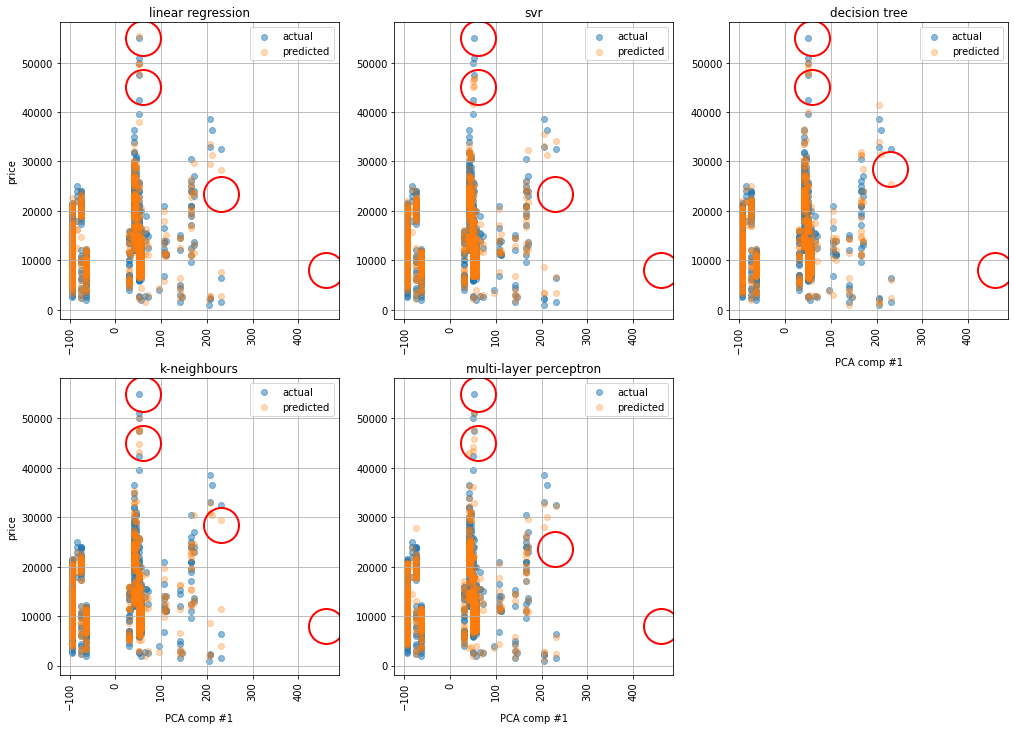

In [117]:
estimators = [
    ('linear regression', lr, X_val),
    ('svr', svr, X_val),
    ('decision tree', dt_mi_, X_val_mi_dt_),
    ('k-neighbours', kn, X_val),
    ('multi-layer perceptron', mlp_mi, X_val_mi),
]

fig = plt.figure(figsize=(17, 12))
feature = 'mileage_enc' #'engineSize' #'year' #'mpg_sqrt'
ax = None
for i, (name, estimator, dataset) in enumerate(estimators):
    ax = plt.subplot(2, 3, i + 1, sharex=ax, sharey=ax)
    X_pca = PCA(1, random_state=9901).fit_transform(dataset)
    ax.scatter(X_pca, y_val, alpha=0.5, label='actual')
    ax.scatter(X_pca, np.exp(estimator.predict(dataset)), 
               alpha=0.3, label='predicted')
    # ax.set_xticks(sorted(X[feature].unique()))
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(name)
    ax.legend()
    if i in [0, 3]:
        ax.set_ylabel('price')
    if i in [2, 3, 4]:
        ax.set_xlabel('PCA comp #1')
    circle_args = dict(marker='o', ms=35, mec='r', mfc='none', mew=2)
    ax.plot(460, 8000, **circle_args)
    if i in [2, 3]:
        ax.plot(230, 28500, **circle_args)
    else:
        ax.plot(230, 23500, **circle_args)
    ax.plot(60, 45000, **circle_args)
    ax.plot(60, 55000, **circle_args)
    # if i in [0, 1]:
    #     ax.set_xticklabels([])
    # if i in [4, 2, 1]:
    #     ax.set_yticklabels([])
    ax.grid()

The circled points highlight some observations that the estimators struggle to predict.

## Fine-Tune the System

### Tune Hyperparameters

In [119]:
def randomized_search(estimator, param_distributions, X=X, y=y, 
                      scoring='neg_mean_squared_error'):
    start = time.time()
    rs = RandomizedSearchCV(
        estimator,
        param_distributions=param_distributions,
        cv=3,
        scoring=scoring,
        n_jobs=n_jobs,
        random_state=9901,
        verbose=1,
        error_score='raise',
    ).fit(X, np.log(y))

    print(f'Randomized search took {time.time() - start:.2f}s')

    return rs


#### Ridge regression

In [122]:
rs_ridge = randomized_search(
    Ridge(),
    {
        'alpha': np.linspace(0.1, 10, 100),
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    },
)

rs_ridge.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Randomized search took 15.14s


{'alpha': 2.9000000000000004, 'solver': 'lsqr'}

In [123]:
_ = fit_regressor(Ridge(**rs_ridge.best_params_), (X_train, y_train), (X_val, y_val))

RMSE: 1326.50
R-squared: 0.9595
Fitting estimator took 0.05s


#### Support Vector Machines

In [ ]:
rs_svr = randomized_search(
    SVR(degree=2), 
    {
        'C': stats.uniform(0, 100),
        'kernel': ['rbf', 'poly'],
        'epsilon': stats.uniform(0.1, 1),
        'tol': stats.uniform(1e-5, 1e-3,)
    },
)
rs_svr.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Randomized search took 17.55s


{'C': 87.65700778166075,
 'epsilon': 0.1445967032099327,
 'kernel': 'rbf',
 'tol': 0.0007114920893851519}

In [ ]:
_ = fit_regressor(SVR(**rs_svr.best_params_), (X_train, y_train), (X_val, y_val))

RMSE: 1833.25
R-squared regressor: 0.9222


#### k-Neighbours

In [127]:
rs_kn = randomized_search(
    KNeighborsRegressor(n_jobs=n_jobs),
    {
        'n_neighbors': np.linspace(5, 50, 10, dtype=np.int8),
        'weights': ['uniform', 'distance'],
        'leaf_size': np.linspace(30, 100, 70, dtype=np.int8),
    },
)
rs_kn.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Randomized search took 11.04s


{'leaf_size': 42, 'n_neighbors': 5, 'weights': 'uniform'}

In [128]:
_ = fit_regressor(KNeighborsRegressor(**rs_kn.best_params_), 
                  (X_train, y_train), (X_val, y_val))

RMSE: 1315.53
R-squared: 0.9601
Fitting estimator took 0.16s


#### Decision Tree

In [125]:
rs_dt = randomized_search(
    DecisionTreeRegressor(random_state=9901),
    {
        'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
        'splitter': ['random', 'best'],
        'min_samples_split': np.linspace(2, 20, 10, dtype=np.int8),
        'min_samples_leaf': np.linspace(0.01, 0.2, 10),
        'min_impurity_decrease': np.linspace(0.0, 0.5, 5),
    },
    X=pd.concat([X_train_mi_dt_, X_val_mi_dt_, X_test[X_train_mi_dt_.columns]]),
)
rs_dt.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Randomized search took 2.83s


{'criterion': 'absolute_error',
 'min_impurity_decrease': 0.375,
 'min_samples_leaf': 0.11555555555555555,
 'min_samples_split': 2,
 'splitter': 'random'}

In [ ]:
_ = fit_regressor(KNeighborsRegressor(**rs_kn.best_params_), 
                  (X_train, y_train), (X_val, y_val))

RMSE: 1596.16
R-squared regressor: 0.9410


#### Multi-layer Perceptron

In [ ]:
rs_mlp = randomized_search(
    MLPRegressor(random_state=9901, early_stopping=True),
    {
        'hidden_layer_sizes': stats.randint(100, 500),
        'activation': ['tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'alpha': stats.uniform(0.0001, 0.1),
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        # 'learning_rate_init': stats.uniform(0.0001, 0.1),
        # 'tol': stats.uniform(1e-6, 1e-4),
        'max_iter': stats.randint(100, 1000),
    },
    X=pd.concat([X_train_mi, X_val_mi, X_test_mi]).to_numpy(),
)
rs_mlp.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Randomized search took 288.69s


{'activation': 'tanh',
 'alpha': 0.01691289225696918,
 'hidden_layer_sizes': 317,
 'learning_rate': 'constant',
 'max_iter': 878,
 'solver': 'lbfgs'}

Hyperparameters tuning with random search improved performance. Multi-layer perceptron is by far the slowest estimator though.

In [ ]:
mlp_best = fit_regressor(MLPRegressor(random_state=9901, early_stopping=True,
                                      **rs_mlp.best_params_), 
                         (X_train_mi, y_train), (X_val_mi, y_val))

RMSE: 1433.47
R-squared: 0.9527
Fitting estimator took 64.52s


### Ensemble Methods

In [144]:
std_scaler = StandardScaler().fit(X_train)
X_train_std = std_scaler.transform(X_train)
X_val_std = std_scaler.transform(X_val)
X_test_std = std_scaler.transform(X_test)

#### Random Forests

In [129]:
features_rf = get_selected_features(
    RandomForestRegressor(n_estimators=10, random_state=9901),
    X,
    # pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns),
    y,
)
print(f"Selected features: {', '.join(features_rf)}")

Total feature count:34           	Selected feature count: 30
Selected features: year, tax, engineSize, mpg_sqrt, fuelType_Hybrid, fuelType_Other, fuelType_Petrol, transmission_Manual, transmission_Semi-Auto, model_ Avensis, model_ Aygo, model_ C-HR, model_ Corolla, model_ GT86, model_ Hilux, model_ IQ, model_ Land Cruiser, model_ PROACE VERSO, model_ Prius, model_ RAV4, model_ Urban Cruiser, model_ Verso, model_ Verso-S, model_ Yaris, mileage_enc, engineSize__transmission_Manual, engineSize__transmission_Semi-Auto, engineSize__fuelType_Hybrid, engineSize__fuelType_Other, engineSize__fuelType_Petrol


Vanilla random forest has great performance.

In [130]:
rf = fit_regressor(
    RandomForestRegressor(random_state=9901, oob_score=True, n_jobs=n_jobs), 
    (X_train, y_train), 
    (X_val, y_val),
)

RMSE: 1208.06
R-squared: 0.9664
Fitting estimator took 1.05s


We can look at the most important features of the regressor. The top 3 looks familiar.

In [ ]:
pd.DataFrame(rf['randomforestregressor'].feature_importances_, 
             index=X_train.columns, columns=['importance']) \
    .sort_values(by='importance', ascending=False).head(10)

,importance
engineSize,0.527740
year,0.316950
mpg_sqrt,0.058197
engineSize__transmission_Manual,0.023378
mileage_enc,0.022263
model_ Land Cruiser,0.008980
tax,0.008279
model_ C-HR,0.007317
model_ Prius,0.005444
engineSize__fuelType_Petrol,0.005404


Dropping a bunch of uniformative features yields slightly better performance. The estimator is simpler therefore the restricted feature set should be preferred.

In [ ]:
X_train_rf, X_val_rf = drop_uniformative_features(
   X_train,
   X_val,
   rf['randomforestregressor'],
   threshold=0.0001,
)

rf_ = fit_regressor(RandomForestRegressor(random_state=9901), 
                    (X_train_rf, y_train), (X_val_rf, y_val))

Dropping: ['transmission_Other', 'model_ Camry', 'model_ GT86', 'model_ IQ', 'model_ Supra', 'model_ Urban Cruiser', 'model_ Verso-S', 'engineSize__transmission_Other', 'engineSize__fuelType_Other']
RMSE: 1203.45
R-squared regressor: 0.9666


In [ ]:
# rs_rf = randomized_search(
#     RandomForestRegressor(random_state=9901, n_jobs=n_jobs),
#     {
#         'n_estimators': np.arange(100, 1000, 10),
#         'criterion': ['squared_error', 'absolute_error', 'poisson'],
#         'max_samples': np.arange(0.5, 1., 10),
#         # 'bootstrap': [True, False],
#         # 'max_leaf_nodes': [100, 1000, 10000, None],
#         # 'min_samples_split': stats.randint(2, 20),
#         # 'min_samples_leaf': stats.uniform(0.01, 0.2),
#         # 'min_impurity_decrease': stats.uniform(0.0, 0.5),
#     },
#     X=pd.concat([X_train_rf, X_val_rf, X_test[X_train_rf.columns]]),
# )

# rs_rf.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Randomized search took 2448.27s


{'criterion': 'absolute_error', 'max_samples': 0.5, 'n_estimators': 750}

In [138]:
from typing import NamedTuple

class RandomizedSearch(NamedTuple):
    best_params_: dict

rs_rf = RandomizedSearch({
    'criterion': 'absolute_error', 
    'max_samples': 0.5, 
    'n_estimators': 750,
})
rs_rf.best_params_

{'criterion': 'absolute_error', 'max_samples': 0.5, 'n_estimators': 750}

In [139]:
rf_best = fit_regressor(RandomForestRegressor(random_state=9901, n_jobs=n_jobs,
                                              **rs_rf.best_params_), 
                        (X_train_rf, y_train), (X_val_rf, y_val))

NameError: ignored

#### Extreme Gradient Boosting

Extreme gradient boosting beats all other estimators, even with no tuning.

In [ ]:
def train_xgb(train_data, val_data):
    X_train, y_train = train_data
    X_val, y_val = val_data
    dtrain = xgb.DMatrix(data=X_train, label=np.log(y_train))
    dval = xgb.DMatrix(data=X_val, label=np.log(y_val))
    evals = [(dtrain, 'train'), (dval, 'val')]
    params = {
        'eval_metric': 'rmse',
        'nthread': n_jobs,
    }
    return xgb.train(params, dtrain, num_boost_round=100, evals=evals, 
                     verbose_eval=False, early_stopping_rounds=30)

xbst = train_xgb((X_train, y_train), (X_val, y_val))
y_pred_xgb = np.exp(xbst.predict(dval))

get_scores(y_val, y_pred_xgb)

RMSE: 1073.13
R-squared: 0.9735


In [ ]:
xgb_top_features = pd.DataFrame(xbst.get_fscore(), 
                                  index=pd.Index(['importance'])) \
    .transpose() \
    .sort_values(by='importance', ascending=False).head(25)
xgb_top_features 

,importance
year,776
mpg_sqrt,637
mileage_enc,577
tax,408
engineSize,173
engineSize__transmission_Manual,84
transmission_Manual,58
model_ Yaris,49
engineSize__fuelType_Petrol,38
model_ C-HR,37


Removing some of the less important features hurts performance.

In [ ]:
_ = fit_regressor(xgb.XGBRegressor(random_state=9901, n_jobs=n_jobs,
                                   **rs_xgb.best_params_), 
                  (X_train[xgb_top_features.index], y_train), 
                  (X_val[xgb_top_features.index], y_val))

RMSE: 1089.12
R-squared regressor: 0.9727
Fitting estimator took 4.28s


In [142]:
# rs_xgb = randomized_search(
#     xgb.XGBRegressor(n_jobs=n_jobs, random_state=9901),
#     {
#         'n_estimators': np.linspace(1000, 10000, 10, dtype=np.int16),
#         'max_depth': np.linspace(1, 10, 10, dtype=np.int8),
#         'learning_rate': np.linspace(0.001, 1., 10),
#         'objective': ['reg:squarederror'],
#         # 'subsample': np.linspace(0.5, 1., 10),
#         # 'reg_alpha': np.linspace(0, 1, 10).tolist() + np.linspace(1, 10, 10).tolist(),
#         'reg_lambda': np.linspace(1, 10, 10),
#     },
# )

# rs_xgb.best_params_

rs_xgb = RandomizedSearch({
    'learning_rate': 0.112,
    'max_depth': 2,
    'n_estimators': 10000,
    'objective': 'reg:squarederror',
    'reg_lambda': 7.0,
})

After trying randomised search a bunch of times, it couldn't find a combination of parameters performing better than the defaults.

In [145]:
_ = fit_regressor(xgb.XGBRegressor(random_state=9901, n_jobs=n_jobs,
                                   **rs_xgb.best_params_), 
                  (X_train_std, y_train), (X_val_std, y_val))

RMSE: 1089.92
R-squared: 0.9726
Fitting estimator took 38.05s


#### Bagging


A voting regressor has very good performance, not enough to beat extreme gradient boosting though. Moreover, it's much much slower.

In [ ]:
estimators = [
    # ('lr', LinearRegression()),
    ('ridge', Ridge(**rs_ridge.best_params_)),
    ('kn', KNeighborsRegressor(n_jobs=n_jobs, **rs_kn.best_params_)),
    ('svr', SVR(**rs_svr.best_params_)),
    # MLP is very slow and doesn't give any real benefit
    # ('mlp', MLPRegressor(random_state=9901, **rs_mlp.best_params_)),
    ('rf', RandomForestRegressor(random_state=9901, oob_score=True)),
    ('xgb', xgb.XGBRegressor(n_jobs=n_jobs, random_state=9901, 
                             **rs_xgb.best_params_)),
]

voting_regressor = VotingRegressor(estimators, n_jobs=n_jobs)
bag = fit_regressor(
    voting_regressor,
    (X_train_std, y_train),
    (X_val_std, y_val),
    scale_input=False,
)

RMSE: 1081.44
R-squared: 0.9731
Fitting estimator took 37.83s


#### Stacking

Stacking is slightly less performant than bagging on this dataset.

In [ ]:
# final_estimator = xgb.XGBRegressor(n_jobs=n_jobs, random_state=9901)
# final_estimator = KNeighborsRegressor(n_jobs=n_jobs)
final_estimator = RandomForestRegressor(random_state=9901)
stacking_regressor = StackingRegressor(estimators, 
                                       final_estimator=final_estimator, 
                                       cv=3, n_jobs=n_jobs)
stack = fit_regressor(
    stacking_regressor,
    (X_train_std, y_train),
    (X_val_std, y_val),
    scale_input=False,
)

RMSE: 1098.92
R-squared: 0.9722
Fitting estimator took 102.29s


### 🥁 Performance on the test set

The bagging regressor turned out to be the one that generalises better. Extreme gradient boosting is a close second and it's also slightly faster.

In [ ]:
dtest = xgb.DMatrix(data=X_test, label=np.log(y_test))
y_pred_xgb = np.exp(xbst.predict(dtest))
get_scores(y_test, y_pred_xgb)

RMSE: 1182.18
R-squared: 0.9658


In [ ]:
y_pred_vr = np.exp(voting_regressor.predict(X_test_std))
get_scores(y_test, y_pred_vr)

RMSE: 1134.61
R-squared: 0.9685


In [ ]:
y_pred_sr = np.exp(stacking_regressor.predict(X_test_std))
get_scores(y_test, y_pred_sr)

RMSE: 1221.57
R-squared: 0.9635


In [ ]:
y_pred_mlp = np.exp(mlp_best.predict(X_test[X_train_mi.columns]))
get_scores(y_test, y_pred_mlp)

## 🗑 ¡¡¡ Delete before submissions !!!

In [ ]:
# normal and log-normal
mu, sigma = df_eda.price.mean(), df_eda.price.std()
normal_std = np.sqrt(np.log(1 + (sigma/mu)**2))
normal_mean = np.log(mu**2 / np.sqrt(mu ** 2 + sigma ** 2))
# normal_mean = np.log(mu) - normal_std**2 / 2
xs = rng.lognormal(normal_mean, normal_std, df_eda.shape[0])
# xs.min(), xs.max(), np.log(df_eda.price).max()
ax = sns.ecdfplot(df_eda['price'], label='Empirical CDF')
_ = sns.ecdfplot(rng.lognormal(normal_mean, normal_std, df_eda.shape[0]), ax=ax,
                 label='Theoretical CDF') 
_ = ax.legend()

In [ ]:
# y = b0 + b1*x + eps
# np.log(10000 + 0.235 * 2018), \
# np.exp(np.log(10000) + 0.235 * 2019))
import sklearn
pipe_tmp = sklearn.clone(pipe_lr).fit(X_train_lr[['year']], y_train)
pipe_tmp_log = sklearn.clone(pipe_lr).fit(X_train_lr[['year']], np.log(y_train))


[2582.69720426]
[0.25410856]


In [ ]:
print(pipe_tmp['linearregression'].coef_)
print(pipe_tmp['linearregression'].intercept_)
print(pipe_tmp_log['linearregression'].coef_)
print(pipe_tmp_log['linearregression'].intercept_)

[2582.69720426]
12523.15974025974
[0.25410856]
9.32651521444724


In [ ]:
z = pipe_tmp_log.predict(X_val_lr.iloc[0, 0].reshape(-1, 1))[0]

x = ((X_val.iloc[0, 0] - X_train_lr.year.mean()) / X_train_lr.year.std())
y = pipe_tmp_log['linearregression'].intercept_ \
    + pipe_tmp_log['linearregression'].coef_[0] * x
print(z, y)
print(np.exp(z), np.exp(y))
np.exp(pipe_tmp_log['linearregression'].intercept_) \
    * (np.exp(0.25410856 * x)) # e^(x*b1) = e^x*e^b1
    # * np.exp(pipe_tmp_log['linearregression'].coef_[0] * x)


9.586203546077599 9.586179455133479
14562.478677159568 14562.127857525318


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


14562.127868406225

In [ ]:
x = ((X_val.iloc[0, 0] - X_train_lr.year.mean()) / X_train_lr.year.std())
pipe_tmp['linearregression'].intercept_ \
    + pipe_tmp['linearregression'].coef_[0] * x
# X_val.iloc[0, 0]

15162.323530715232

In [ ]:
np.exp(0.23462411), np.log(1964.6844993)
display(X_val.iloc[:1, 0], y_val.iloc[:1])
pipe_tmp.predict(X_val_lr.iloc[0, 0].reshape(-1, 1))
# X_val_lr.iloc[:1, 0]

6704    2019
Name: year, dtype: int64

6704    51995
Name: price, dtype: int32

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


array([15162.56838518])

## Conclusions

I implemented an estimator with an average error (RMSE) of £1,200 which is within the upper bound of £1,500 critical for business purposes. The best estimator turned out to be a voting regressor that uses tuned extreme gradient booster, ridge, SVM, k-neighbour and random forest regressors. A very close second is a vanilla extreme gradient booster.

## Further improvements

1. Should the estimator penalise predictions that are below the target price? The reason being that by suggesting a lower price the business could be missing on some revenues and effectively selling a car at a discount. We should make sure this is clarified with sales. Until that's the case, predicted prices should be double checked by a sale person.
2. There is no quantitative data on the "appeal" of a car. This data could be sourced from a different provider or perhaps total sales in the UK for a given model could be taken as a measure of that.
3. Mileage has been bucketised using deciles. With the assistance of sales, we should be able to come up with a more exact measure of "usage".
4. There is no data about the overall aesthetic state of the car, which must play a role in its price.